In [113]:
#### Julia 1.7.3 #####
# using LinearAlgebra
# using PyPlot
# using RandomMatrix
# using ITensors
# # using TensorOperations
using LsqFit
using ITensors, PyPlot, Polynomials

# Numerical many-body methods - Problem Set 3 
## (DMRG)
Noam Ophir

# $J_1-J_2$ spin-1/2 chain
*In this problem we will revisit the spin-1/2 antiferromagnetic $J_1-J_2$ chain discussed in Problem Set 1, given by the Hamiltonian*
$$
H
=
J_1\sum_i\vec{S}_i\cdot\vec{S}_{i+1}+J_2\sum_i\vec{S}_i\cdot\vec{S}_{i+2}
$$
*Recall that the model exhibits a phase transition between a gapless and a dimerized phase at $g_c\simeq 0.241$, where $g$ is the dimensionless ratio $J_2/J_1$.*

*We will now solve the problem using DMRG and employing the ITensor library. In sections 2,3 below use values of $g\leq1/2$. (For $g > 1/2$ the system is still dimerized but exhibitis incommensurate spin-spin correlations, reminiscent of the classical ordering, which can give rise to large finite-size effects.)*

## 1-1
*Generalize the construction of the Heisenberg Hamiltonian discussed in class to allow for a finite $J_2$ term.*

In [5]:
function J1J2Hamiltonian(sites, J2)
    N = length(sites)
    # Initialize an operator sum representing the Hamiltonian using ITensors
    ampo = OpSum()

    # Construct the Hamiltonian operator for the 1D quantum system
    for j = 1:N-1
        # Heisenberg interaction term (Sz-Sz)
        ampo += "Sz", j, "Sz", j+1
        # Spin-flip terms (S+, S- and S-, S+) with coupling strength 1/2
        ampo += 1/2, "S+", j, "S-", j+1
        ampo += 1/2, "S-", j, "S+", j+1
    end
    for j = 1:N-2
        # Heisenberg interaction term (Sz-Sz)
        ampo += J2, "Sz", j, "Sz", j+2
        # Spin-flip terms (S+, S- and S-, S+) with coupling strength 1/2
        ampo += J2/2, "S+", j, "S-", j+2
        ampo += J2/2, "S-", j, "S+", j+2
    end

    # Convert the operator sum to a Matrix Product Operator (MPO)
    H = MPO(ampo, sites)
    return H
end

# Number of sites in the 1D quantum system
N = 100

# Generate an index set representing quantum sites with spin S=1/2, conserving quantum numbers
sites = siteinds("S=1/2", N; conserve_qns=true)

J2 = 1.0
H = J1J2Hamiltonian(sites, J2)

flux(psi0) = QN("Sz",0)


MPO
[1] ((dim=5|id=1|"Link,l=1") <Out>
 1: QN() => 1
 2: QN("Sz",2) => 1
 3: QN("Sz",0) => 1
 4: QN("Sz",-2) => 1
 5: QN("Sz",0) => 1, (dim=2|id=571|"S=1/2,Site,n=1")' <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=2|id=571|"S=1/2,Site,n=1") <In>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1)
[2] ((dim=5|id=1|"Link,l=1") <In>
 1: QN() => 1
 2: QN("Sz",2) => 1
 3: QN("Sz",0) => 1
 4: QN("Sz",-2) => 1
 5: QN("Sz",0) => 1, (dim=8|id=533|"Link,l=2") <Out>
 1: QN() => 1
 2: QN("Sz",2) => 2
 3: QN("Sz",0) => 2
 4: QN("Sz",-2) => 2
 5: QN("Sz",0) => 1, (dim=2|id=445|"S=1/2,Site,n=2")' <Out>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1, (dim=2|id=445|"S=1/2,Site,n=2") <In>
 1: QN("Sz",1) => 1
 2: QN("Sz",-1) => 1)
[3] ((dim=8|id=533|"Link,l=2") <In>
 1: QN() => 1
 2: QN("Sz",2) => 2
 3: QN("Sz",0) => 2
 4: QN("Sz",-2) => 2
 5: QN("Sz",0) => 1, (dim=8|id=452|"Link,l=3") <Out>
 1: QN() => 1
 2: QN("Sz",2) => 2
 3: QN("Sz",0) => 2
 4: QN("Sz",-2) => 2
 5: QN("Sz",0) => 1, (dim=2|id=956|"S=1/2,Site,n

## 1-2
*Perform finite-size scaling of the triplet gap (i.e. the energy gap between the ground state in the $S^z = 0$ sector to the lowest state in the $S^z = 1$ sector) for different values of $g$ across the phase transition. To find the lowest energy state in each $S^z$ sector you will need to make sure that the initial state is in the same $S^z$ sector. You can now easily access system sizes of up to $N = 100$ sites (performing e.g. 10 sweeps with bond dimensions of order 100), but to clearly observe a finite gap for $g > g_c$ it is still advisable to consider values of g close enough to $g = 1/2$.*

In [7]:
Ns = 20:20:60
gs = [0.2, 0.4, 0.6, 0.8]
E_singlet = zeros(length(Ns),length(gs))
E_triplet = zeros(length(Ns),length(gs))

for (i,N) in enumerate(Ns)
    for (j,g) in enumerate(gs)
        sites = siteinds("S=1/2", N; conserve_qns=true)
        H = J1J2Hamiltonian(sites, g)
        
        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
        psi0 = productMPS(sites, state0)
        @show flux(psi0)
        E_singlet[i,j],psi = dmrg(H,psi0; nsweeps=10, maxdim=100, cutoff=1E-10)

        state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
        state0[2] = "Up"

        psi0 = productMPS(sites, state0)
        @show flux(psi0)
        E_triplet[i,j],psi = dmrg(H,psi0; nsweeps=10, maxdim=100, cutoff=1E-10)
    end
end

flux(psi0) = QN("Sz",0)
After sweep 1 energy=-8.003089405267295  maxlinkdim=4 maxerr=1.12E-15 time=1.311


After sweep 2 energy=-8.063759806230028  maxlinkdim=16 maxerr=9.44E-16 time=0.207


After sweep 3 energy=-8.064121355982028  maxlinkdim=36 maxerr=9.87E-11 time=0.266


After sweep 4 energy=-8.064121440962039  maxlinkdim=34 maxerr=9.95E-11 time=0.276


After sweep 5 energy=-8.064121440968705  maxlinkdim=34 maxerr=9.94E-11 time=0.277


After sweep 6 energy=-8.064121440969204  maxlinkdim=34 maxerr=9.94E-11 time=0.264


After sweep 7 energy=-8.064121440969316  maxlinkdim=34 maxerr=9.93E-11 time=0.276


After sweep 8 energy=-8.06412144096936  maxlinkdim=34 maxerr=9.93E-11 time=0.258


After sweep 9 energy=-8.064121440969362  maxlinkdim=34 maxerr=9.93E-11 time=0.277


After sweep 10 energy=-8.064121440969371  maxlinkdim=34 maxerr=9.93E-11 time=0.260


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-7.366082852463103  maxlinkdim=4 maxerr=1.11E-15 time=0.060


After sweep 2 energy=-7.8648102481381965  maxlinkdim=16 maxerr=1.21E-15 time=0.194


After sweep 3 energy=-7.89302546234288  maxlinkdim=42 maxerr=9.74E-11 time=0.271


After sweep 4 energy=-7.893053530413824  maxlinkdim=33 maxerr=9.99E-11 time=0.300


After sweep 5 energy=-7.893053531858671  maxlinkdim=33 maxerr=9.92E-11 time=0.268


After sweep 6 energy=-7.8930535317778485  maxlinkdim=32 maxerr=9.86E-11 time=0.252


After sweep 7 energy=-7.893053531777862  maxlinkdim=32 maxerr=9.84E-11 time=0.271


After sweep 8 energy=-7.893053531777859  maxlinkdim=32 maxerr=9.84E-11 time=0.253


After sweep 9 energy=-7.893053531777851  maxlinkdim=32 maxerr=9.84E-11 time=0.259


After sweep 10 energy=-7.893053531777867  maxlinkdim=32 maxerr=9.84E-11 time=0.263


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-7.559319649604028  maxlinkdim=4 maxerr=1.06E-15 time=0.077


After sweep 2 energy=-7.587847713988481  maxlinkdim=16 maxerr=9.86E-11 time=0.246


After sweep 3 energy=-7.587940873678277  maxlinkdim=34 maxerr=9.79E-11 time=0.295


After sweep 4 energy=-7.58794101315237  maxlinkdim=33 maxerr=9.81E-11 time=0.274


After sweep 5 energy=-7.587941013062549  maxlinkdim=32 maxerr=9.89E-11 time=0.284


After sweep 6 energy=-7.587941013062537  maxlinkdim=32 maxerr=9.81E-11 time=0.332


After sweep 7 energy=-7.58794101306253  maxlinkdim=32 maxerr=9.81E-11 time=0.296


After sweep 8 energy=-7.587941013062543  maxlinkdim=32 maxerr=9.81E-11 time=0.295


After sweep 9 energy=-7.587941013062538  maxlinkdim=32 maxerr=9.81E-11 time=0.271


After sweep 10 energy=-7.58794101306255  maxlinkdim=32 maxerr=9.81E-11 time=0.281


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-6.951470283810682  maxlinkdim=4 maxerr=6.67E-16 time=0.097


After sweep 2 energy=-7.335589348504337  maxlinkdim=16 maxerr=9.45E-16 time=0.181


After sweep 3 energy=-7.386162068191003  maxlinkdim=55 maxerr=9.48E-11 time=0.266


After sweep 4 energy=-7.387693016726155  maxlinkdim=59 maxerr=9.79E-11 time=0.373


After sweep 5 energy=-7.387699504785957  maxlinkdim=37 maxerr=9.84E-11 time=0.337


After sweep 6 energy=-7.387699507447618  maxlinkdim=35 maxerr=9.98E-11 time=0.303


After sweep 7 energy=-7.387699507452085  maxlinkdim=35 maxerr=9.69E-11 time=0.296


After sweep 8 energy=-7.3876995074520115  maxlinkdim=35 maxerr=9.68E-11 time=0.293


After sweep 9 energy=-7.387699507451989  maxlinkdim=35 maxerr=9.68E-11 time=0.319


After sweep 10 energy=-7.387699507451977  maxlinkdim=35 maxerr=9.68E-11 time=0.300


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-7.5778770362983545  maxlinkdim=4 maxerr=1.06E-15 time=0.072


After sweep 2 energy=-7.600450732350842  maxlinkdim=16 maxerr=6.53E-11 time=0.211


After sweep 3 energy=-7.600533523779125  maxlinkdim=43 maxerr=9.60E-11 time=0.280


After sweep 4 energy=-7.600533564625513  maxlinkdim=48 maxerr=9.89E-11 time=0.328


After sweep 5 energy=-7.600533564633626  maxlinkdim=48 maxerr=9.36E-11 time=0.336


After sweep 6 energy=-7.600533564633624  maxlinkdim=48 maxerr=9.36E-11 time=0.341


After sweep 7 energy=-7.600533564633656  maxlinkdim=48 maxerr=9.36E-11 time=0.380


After sweep 8 energy=-7.600533564633672  maxlinkdim=48 maxerr=9.36E-11 time=0.331


After sweep 9 energy=-7.600533564633663  maxlinkdim=48 maxerr=9.36E-11 time=0.345


After sweep 10 energy=-7.600533564633659  maxlinkdim=48 maxerr=9.36E-11 time=0.325


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-6.83964168263456  maxlinkdim=4 maxerr=1.22E-15 time=0.081


After sweep 2 energy=-7.0507188201304025  maxlinkdim=16 maxerr=4.84E-11 time=0.186


After sweep 3 energy=-7.1080241071128825  maxlinkdim=61 maxerr=9.95E-11 time=0.309


After sweep 4 energy=-7.1236689886924145  maxlinkdim=100 maxerr=1.46E-09 time=0.464


After sweep 5 energy=-7.1316035422860935  maxlinkdim=100 maxerr=1.92E-09 time=0.516


After sweep 6 energy=-7.1332799564997735  maxlinkdim=100 maxerr=9.89E-10 time=0.533


After sweep 7 energy=-7.133483806255485  maxlinkdim=100 maxerr=3.71E-10 time=0.529


After sweep 8 energy=-7.133514041209018  maxlinkdim=100 maxerr=1.38E-10 time=0.527


After sweep 9 energy=-7.133521249858333  maxlinkdim=93 maxerr=9.65E-11 time=0.514


After sweep 10 energy=-7.133523470603633  maxlinkdim=88 maxerr=9.92E-11 time=0.464


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-8.124208511821735  maxlinkdim=4 maxerr=9.51E-16 time=0.091


After sweep 2 energy=-8.329911562988901  maxlinkdim=16 maxerr=2.83E-11 time=0.199


After sweep 3 energy=-8.33260535410007  maxlinkdim=59 maxerr=8.83E-11 time=0.310


After sweep 4 energy=-8.33261070202145  maxlinkdim=97 maxerr=9.99E-11 time=0.447


After sweep 5 energy=-8.33261070171576  maxlinkdim=95 maxerr=9.96E-11 time=0.469


After sweep 6 energy=-8.332610701715403  maxlinkdim=95 maxerr=9.75E-11 time=0.454


After sweep 7 energy=-8.332610701715407  maxlinkdim=95 maxerr=9.75E-11 time=0.470


After sweep 8 energy=-8.332610701715423  maxlinkdim=95 maxerr=9.75E-11 time=0.469


After sweep 9 energy=-8.332610701715414  maxlinkdim=95 maxerr=9.75E-11 time=0.481


After sweep 10 energy=-8.33261070171543  maxlinkdim=95 maxerr=9.75E-11 time=0.458


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-7.251760776006333  maxlinkdim=4 maxerr=9.44E-16 time=0.081


After sweep 2 energy=-7.582561923561487  maxlinkdim=16 maxerr=1.77E-11 time=0.190


After sweep 3 energy=-7.80524118290463  maxlinkdim=64 maxerr=7.55E-11 time=0.309


After sweep 4 energy=-7.823134681828298  maxlinkdim=100 maxerr=1.35E-08 time=0.488


After sweep 5 energy=-7.823828740726182  maxlinkdim=100 maxerr=7.92E-09 time=0.535


After sweep 6 energy=-7.823934608065002  maxlinkdim=100 maxerr=4.17E-09 time=0.537


After sweep 7 energy=-7.823970418852427  maxlinkdim=100 maxerr=2.95E-09 time=0.545


After sweep 8 energy=-7.823982720352631  maxlinkdim=100 maxerr=2.49E-09 time=0.569


After sweep 9 energy=-7.823986176179482  maxlinkdim=100 maxerr=5.38E-09 time=0.541


After sweep 10 energy=-7.823986835184913  maxlinkdim=100 maxerr=3.35E-09 time=0.505


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-16.124715451022926  maxlinkdim=4 maxerr=1.12E-15 time=0.154


After sweep 2 energy=-16.22622257512106  maxlinkdim=16 maxerr=8.90E-16 time=0.437


After sweep 3 energy=-16.230623054430072  maxlinkdim=52 maxerr=9.87E-11 time=0.701


After sweep 4 energy=-16.230660398711457  maxlinkdim=63 maxerr=9.85E-11 time=0.910


After sweep 5 energy=-16.23066046525035  maxlinkdim=57 maxerr=9.96E-11 time=0.863


After sweep 6 energy=-16.230660465335728  maxlinkdim=57 maxerr=9.94E-11 time=0.852


After sweep 7 energy=-16.230660465429814  maxlinkdim=57 maxerr=9.93E-11 time=0.888


After sweep 8 energy=-16.230660465429754  maxlinkdim=57 maxerr=9.93E-11 time=0.847


After sweep 9 energy=-16.230660465429715  maxlinkdim=57 maxerr=9.93E-11 time=0.849


After sweep 10 energy=-16.230660465429718  maxlinkdim=57 maxerr=9.93E-11 time=0.832


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-15.470681641614046  maxlinkdim=4 maxerr=4.24E-16 time=0.162


After sweep 2 energy=-16.055588448171502  maxlinkdim=16 maxerr=9.06E-11 time=0.445


After sweep 3 energy=-16.13842304419193  maxlinkdim=54 maxerr=9.96E-11 time=0.736


After sweep 4 energy=-16.141790078922906  maxlinkdim=69 maxerr=9.99E-11 time=0.974


After sweep 5 energy=-16.141823758616706  maxlinkdim=68 maxerr=9.87E-11 time=0.975


After sweep 6 energy=-16.141823767290514  maxlinkdim=56 maxerr=9.99E-11 time=0.857


After sweep 7 energy=-16.14182376694745  maxlinkdim=56 maxerr=9.98E-11 time=0.842


After sweep 8 energy=-16.14182376694833  maxlinkdim=56 maxerr=9.94E-11 time=0.838


After sweep 9 energy=-16.14182376694834  maxlinkdim=56 maxerr=9.93E-11 time=0.843


After sweep 10 energy=-16.141823766948345  maxlinkdim=56 maxerr=9.93E-11 time=0.830


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-15.109869632079524  maxlinkdim=4 maxerr=8.89E-16 time=0.168


After sweep 2 energy=-15.194161723059466  maxlinkdim=16 maxerr=1.11E-15 time=0.433


After sweep 3 energy=-15.195206677026189  maxlinkdim=48 maxerr=9.85E-11 time=0.734


After sweep 4 energy=-15.195227050058056  maxlinkdim=55 maxerr=9.94E-11 time=0.923


After sweep 5 energy=-15.195227212709378  maxlinkdim=52 maxerr=9.93E-11 time=0.805


After sweep 6 energy=-15.195227212117862  maxlinkdim=49 maxerr=9.99E-11 time=0.757


After sweep 7 energy=-15.19522721217036  maxlinkdim=49 maxerr=9.84E-11 time=0.741


After sweep 8 energy=-15.195227212177187  maxlinkdim=49 maxerr=9.84E-11 time=0.791


After sweep 9 energy=-15.195227212178878  maxlinkdim=49 maxerr=9.83E-11 time=0.794


After sweep 10 energy=-15.195227212180269  maxlinkdim=49 maxerr=9.83E-11 time=0.775


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-14.501356990076559  maxlinkdim=4 maxerr=3.89E-16 time=0.161


After sweep 2 energy=-14.947865542435169  maxlinkdim=16 maxerr=9.99E-16 time=0.433


After sweep 3 energy=-15.046163875713896  maxlinkdim=56 maxerr=9.92E-11 time=0.759


After sweep 4 energy=-15.069640147996148  maxlinkdim=97 maxerr=9.96E-11 time=1.142


After sweep 5 energy=-15.073368812463258  maxlinkdim=97 maxerr=9.99E-11 time=1.247


After sweep 6 energy=-15.073791019897262  maxlinkdim=91 maxerr=1.00E-10 time=1.407


After sweep 7 energy=-15.07381936145462  maxlinkdim=84 maxerr=9.95E-11 time=1.117


After sweep 8 energy=-15.07381954906164  maxlinkdim=62 maxerr=9.99E-11 time=0.955


After sweep 9 energy=-15.073819548332205  maxlinkdim=61 maxerr=9.95E-11 time=0.875


After sweep 10 energy=-15.073819548340671  maxlinkdim=61 maxerr=9.84E-11 time=0.887


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-15.165010210945859  maxlinkdim=4 maxerr=1.05E-15 time=0.169


After sweep 2 energy=-15.216479716944338  maxlinkdim=16 maxerr=6.54E-11 time=0.431


After sweep 3 energy=-15.216730617163403  maxlinkdim=45 maxerr=9.87E-11 time=0.656


After sweep 4 energy=-15.216730839487644  maxlinkdim=52 maxerr=9.97E-11 time=0.855


After sweep 5 energy=-15.21673083897339  maxlinkdim=52 maxerr=9.99E-11 time=0.856


After sweep 6 energy=-15.216730839078888  maxlinkdim=52 maxerr=9.97E-11 time=0.897


After sweep 7 energy=-15.216730839077428  maxlinkdim=52 maxerr=9.97E-11 time=0.862


After sweep 8 energy=-15.216730839074929  maxlinkdim=52 maxerr=9.97E-11 time=0.914


After sweep 9 energy=-15.216730839071317  maxlinkdim=52 maxerr=9.97E-11 time=0.890


After sweep 10 energy=-15.216730839068198  maxlinkdim=52 maxerr=9.96E-11 time=0.883


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-14.42677484856184  maxlinkdim=4 maxerr=1.00E-15 time=0.162


After sweep 2 energy=-14.66675861225318  maxlinkdim=16 maxerr=6.54E-11 time=0.408


After sweep 3 energy=-14.725080220255661  maxlinkdim=60 maxerr=9.95E-11 time=0.680


After sweep 4 energy=-14.74527660582815  maxlinkdim=100 maxerr=1.88E-10 time=1.119


After sweep 5 energy=-14.756056826159135  maxlinkdim=100 maxerr=1.50E-09 time=1.405


After sweep 6 energy=-14.762086988254564  maxlinkdim=100 maxerr=2.51E-09 time=1.508


After sweep 7 energy=-14.765233127594009  maxlinkdim=100 maxerr=2.85E-09 time=1.508


After sweep 8 energy=-14.766805158447978  maxlinkdim=100 maxerr=4.31E-09 time=1.540


After sweep 9 energy=-14.767592236258707  maxlinkdim=100 maxerr=3.79E-09 time=1.530


After sweep 10 energy=-14.76800274449741  maxlinkdim=100 maxerr=3.18E-09 time=1.520


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-16.311879553278427  maxlinkdim=4 maxerr=8.92E-16 time=0.153


After sweep 2 energy=-16.7590080845155  maxlinkdim=16 maxerr=2.25E-11 time=0.428


After sweep 3 energy=-16.76690815802758  maxlinkdim=60 maxerr=9.81E-11 time=0.742


After sweep 4 energy=-16.766966885116318  maxlinkdim=100 maxerr=4.13E-10 time=1.347


After sweep 5 energy=-16.766967001481554  maxlinkdim=100 maxerr=7.03E-10 time=1.528


After sweep 6 energy=-16.76696700164254  maxlinkdim=100 maxerr=5.93E-10 time=1.542


After sweep 7 energy=-16.766967001773555  maxlinkdim=100 maxerr=5.94E-10 time=1.526


After sweep 8 energy=-16.766967001821577  maxlinkdim=100 maxerr=5.95E-10 time=1.880


After sweep 9 energy=-16.766967001919024  maxlinkdim=100 maxerr=5.95E-10 time=1.471


After sweep 10 energy=-16.76696700191964  maxlinkdim=100 maxerr=5.95E-10 time=1.550


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-15.4401977521982  maxlinkdim=4 maxerr=9.99E-16 time=0.160


After sweep 2 energy=-16.01150096666413  maxlinkdim=16 maxerr=9.35E-11 time=0.409


After sweep 3 energy=-16.24719668482792  maxlinkdim=64 maxerr=9.69E-11 time=0.736


After sweep 4 energy=-16.31945525950578  maxlinkdim=100 maxerr=1.50E-08 time=1.418


After sweep 5 energy=-16.333864675660624  maxlinkdim=100 maxerr=2.70E-08 time=1.554


After sweep 6 energy=-16.335933964783518  maxlinkdim=100 maxerr=2.50E-08 time=1.622


After sweep 7 energy=-16.336144339312078  maxlinkdim=100 maxerr=1.62E-07 time=1.602


After sweep 8 energy=-16.33616702901674  maxlinkdim=100 maxerr=8.44E-08 time=1.603


After sweep 9 energy=-16.33617123572305  maxlinkdim=100 maxerr=4.64E-08 time=1.593


After sweep 10 energy=-16.33617260875845  maxlinkdim=100 maxerr=4.10E-08 time=1.586


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-24.251085649562242  maxlinkdim=4 maxerr=1.28E-15 time=0.235


After sweep 2 energy=-24.38970526822473  maxlinkdim=16 maxerr=6.12E-11 time=0.615


After sweep 3 energy=-24.399103072188485  maxlinkdim=53 maxerr=9.86E-11 time=1.042


After sweep 4 energy=-24.39954321699473  maxlinkdim=77 maxerr=9.99E-11 time=1.518


After sweep 5 energy=-24.399549254761407  maxlinkdim=76 maxerr=9.98E-11 time=1.636


After sweep 6 energy=-24.399549260530705  maxlinkdim=73 maxerr=9.97E-11 time=1.660


After sweep 7 energy=-24.3995492605179  maxlinkdim=73 maxerr=9.93E-11 time=1.587


After sweep 8 energy=-24.399549260517396  maxlinkdim=73 maxerr=9.97E-11 time=1.566


After sweep 9 energy=-24.39954926051747  maxlinkdim=73 maxerr=9.97E-11 time=1.592


After sweep 10 energy=-24.39954926051738  maxlinkdim=73 maxerr=9.97E-11 time=1.943


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-23.596566122318418  maxlinkdim=4 maxerr=4.45E-16 time=0.223


After sweep 2 energy=-24.21216533398938  maxlinkdim=16 maxerr=7.62E-11 time=0.641


After sweep 3 energy=-24.324698651741627  maxlinkdim=55 maxerr=9.99E-11 time=1.120


After sweep 4 energy=-24.338126199852177  maxlinkdim=79 maxerr=9.99E-11 time=1.558


After sweep 5 energy=-24.3394905330268  maxlinkdim=81 maxerr=9.95E-11 time=1.728


After sweep 6 energy=-24.339519946221458  maxlinkdim=91 maxerr=9.99E-11 time=1.667


After sweep 7 energy=-24.33952014431148  maxlinkdim=73 maxerr=9.99E-11 time=1.586


After sweep 8 energy=-24.33952014323848  maxlinkdim=73 maxerr=1.00E-10 time=1.517


After sweep 9 energy=-24.339520143240765  maxlinkdim=73 maxerr=9.97E-11 time=1.510


After sweep 10 energy=-24.33952014317608  maxlinkdim=73 maxerr=9.99E-11 time=1.492


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-22.65787096115672  maxlinkdim=4 maxerr=8.89E-16 time=0.233


After sweep 2 energy=-22.80079909454675  maxlinkdim=16 maxerr=9.42E-11 time=0.653


After sweep 3 energy=-22.802708861590443  maxlinkdim=51 maxerr=9.99E-11 time=1.065


After sweep 4 energy=-22.80279491598182  maxlinkdim=61 maxerr=9.95E-11 time=1.449


After sweep 5 energy=-22.8027982980251  maxlinkdim=68 maxerr=9.98E-11 time=1.457


After sweep 6 energy=-22.8027983737448  maxlinkdim=62 maxerr=1.00E-10 time=1.417


After sweep 7 energy=-22.802798373066334  maxlinkdim=60 maxerr=9.97E-11 time=1.368


After sweep 8 energy=-22.80279837325618  maxlinkdim=60 maxerr=9.95E-11 time=1.354


After sweep 9 energy=-22.802798373255705  maxlinkdim=60 maxerr=9.91E-11 time=1.363


After sweep 10 energy=-22.802798373272694  maxlinkdim=60 maxerr=9.93E-11 time=1.354


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-22.048034546356437  maxlinkdim=4 maxerr=8.88E-16 time=0.237


After sweep 2 energy=-22.552723384139306  maxlinkdim=16 maxerr=9.44E-16 time=0.601


After sweep 3 energy=-22.653516501953803  maxlinkdim=57 maxerr=9.97E-11 time=1.052


After sweep 4 energy=-22.686337460168165  maxlinkdim=87 maxerr=9.98E-11 time=1.642


After sweep 5 energy=-22.70177649649897  maxlinkdim=100 maxerr=1.21E-10 time=1.850


After sweep 6 energy=-22.707045491929993  maxlinkdim=99 maxerr=9.97E-11 time=1.919


After sweep 7 energy=-22.708777304226334  maxlinkdim=100 maxerr=9.94E-11 time=1.960


After sweep 8 energy=-22.709299079260838  maxlinkdim=96 maxerr=1.08E-10 time=1.987


After sweep 9 energy=-22.709423935162395  maxlinkdim=91 maxerr=9.99E-11 time=2.131


After sweep 10 energy=-22.709455491439037  maxlinkdim=100 maxerr=2.62E-10 time=1.805


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-22.752143385781842  maxlinkdim=4 maxerr=1.11E-15 time=0.240


After sweep 2 energy=-22.83250871266613  maxlinkdim=16 maxerr=6.54E-11 time=0.628


After sweep 3 energy=-22.83292764416137  maxlinkdim=45 maxerr=9.86E-11 time=0.985


After sweep 4 energy=-22.83292814257913  maxlinkdim=53 maxerr=9.98E-11 time=1.331


After sweep 5 energy=-22.832928142087727  maxlinkdim=53 maxerr=1.00E-10 time=1.385


After sweep 6 energy=-22.832928142206807  maxlinkdim=53 maxerr=9.97E-11 time=1.389


After sweep 7 energy=-22.832928142091404  maxlinkdim=53 maxerr=9.99E-11 time=1.436


After sweep 8 energy=-22.83292814197873  maxlinkdim=53 maxerr=9.97E-11 time=1.383


After sweep 9 energy=-22.832928141709782  maxlinkdim=53 maxerr=9.95E-11 time=1.452


After sweep 10 energy=-22.8329281417543  maxlinkdim=53 maxerr=9.92E-11 time=1.415


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-22.013908023397825  maxlinkdim=4 maxerr=1.11E-15 time=0.233


After sweep 2 energy=-22.28278760795497  maxlinkdim=16 maxerr=6.54E-11 time=0.596


After sweep 3 energy=-22.340941307119937  maxlinkdim=59 maxerr=9.93E-11 time=1.006


After sweep 4 energy=-22.36003630396986  maxlinkdim=100 maxerr=1.38E-10 time=1.596


After sweep 5 energy=-22.370995325677992  maxlinkdim=100 maxerr=9.03E-10 time=1.971


After sweep 6 energy=-22.378356878108036  maxlinkdim=100 maxerr=1.92E-09 time=2.143


After sweep 7 energy=-22.383299052002716  maxlinkdim=100 maxerr=2.57E-09 time=2.269


After sweep 8 energy=-22.386775441036058  maxlinkdim=100 maxerr=3.37E-09 time=2.284


After sweep 9 energy=-22.389361289652168  maxlinkdim=100 maxerr=4.62E-09 time=2.322


After sweep 10 energy=-22.3913822855222  maxlinkdim=100 maxerr=5.69E-09 time=2.379


flux(psi0) = QN("Sz",0)
After sweep 1 energy=-24.50065383384542  maxlinkdim=4 maxerr=1.00E-15 time=0.225


After sweep 2 energy=-25.18810303098684  maxlinkdim=16 maxerr=2.25E-11 time=0.639


After sweep 3 energy=-25.20121250111608  maxlinkdim=60 maxerr=9.99E-11 time=1.524


After sweep 4 energy=-25.201331817046555  maxlinkdim=100 maxerr=4.30E-10 time=2.217


After sweep 5 energy=-25.201332306736177  maxlinkdim=100 maxerr=9.49E-10 time=2.539


After sweep 6 energy=-25.20133230781185  maxlinkdim=100 maxerr=7.60E-10 time=2.542


After sweep 7 energy=-25.201332307652876  maxlinkdim=100 maxerr=7.63E-10 time=2.538


After sweep 8 energy=-25.20133230786253  maxlinkdim=100 maxerr=7.63E-10 time=2.520


After sweep 9 energy=-25.20133230792027  maxlinkdim=100 maxerr=7.63E-10 time=2.556


After sweep 10 energy=-25.201332307924794  maxlinkdim=100 maxerr=7.63E-10 time=2.568


flux(psi0) = QN("Sz",2)
After sweep 1 energy=-23.629313150984668  maxlinkdim=4 maxerr=1.17E-15 time=0.218


After sweep 2 energy=-24.440595481656782  maxlinkdim=16 maxerr=7.99E-12 time=0.601


After sweep 3 energy=-24.68150494069736  maxlinkdim=64 maxerr=9.93E-11 time=1.118


After sweep 4 energy=-24.757811273444567  maxlinkdim=100 maxerr=1.66E-08 time=2.313


After sweep 5 energy=-24.782618834051803  maxlinkdim=100 maxerr=1.88E-08 time=2.937


After sweep 6 energy=-24.793208242285544  maxlinkdim=100 maxerr=2.11E-08 time=2.591


After sweep 7 energy=-24.79761665998209  maxlinkdim=100 maxerr=2.60E-08 time=2.825


After sweep 8 energy=-24.799301586169282  maxlinkdim=100 maxerr=9.49E-07 time=2.700


After sweep 9 energy=-24.79988704558668  maxlinkdim=100 maxerr=7.72E-07 time=2.671


After sweep 10 energy=-24.80012135354749  maxlinkdim=100 maxerr=2.00E-07 time=2.605


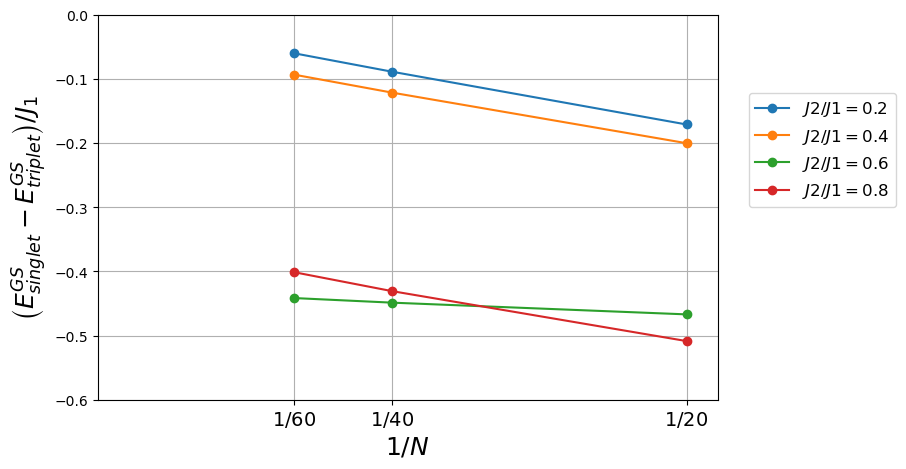

In [64]:
fig,ax = subplots(figsize=(8,5))
for i in 1:length(J2s)
    ax.plot(1 ./Ns,E_singlet[:,i]-E_triplet[:,i],"-o",label=L"J2/J1="*string(J2s[i])*"")
end
# ax.set_xlim([0,1])
# ax.set_xscale("log")
ax.legend(loc=(1.05,0.5),fontsize=12)
ax.set_xlabel(L"$1/N$", fontsize=18)
ax.set_xticks(1 ./Ns)
ax.set_xticklabels([L"1/" * string(N) for N in Ns], fontsize=14)
ax.set_ylabel(L"\left(E^{GS}_{singlet}-E^{GS}_{triplet}\right)/J_1",fontsize=18)
ax.set_xlim([0,1/19])
ax.set_ylim([-0.6,0])
ax.grid()

gcf()

## 1-3
*Calculate the spin-spin correlations (i.e. the expectation value of $\langle\vec{S}_{x_0} \cdot \vec{S}_{x_0+x} \rangle$ as function of $x$) for different values of g across the phase transition. Show that for $g\leq g_c$ the correlations decay as a power law (i.e.  $1/x^\alpha$), while for $g > g_c$ the decay is exponential (i.e. $\sim\exp(-x\xi)$) . Use system sizes of $N = 200$ sites and calculate the correlations with respect to a site in the middle of the system to avoid boundary effects. (Recall that we are now working with open boundary conditions as opposed to all the calculations we performed using Exact Diagonalization.) For $g\leq g_c$ calculate the exponent $\alpha$, and for $g > g_c$ obtain the correlation length $\xi$. Note: to obtain the spin-spin correlations you can use the built in ITensor function `correlation matrix(psi,"Sz","Sz")` that calculates the full correlation matrix $\langle \psi|S^z_i S^z_j|\psi \rangle$ for every pair of sites $(i,j)$ in the system.*

In [76]:
N = 200
correlations = []
for (j,g) in enumerate(J2s)
    sites = siteinds("S=1/2", N; conserve_qns=true)
    H = J1J2Hamiltonian(sites, g)
    
    state0 = [isodd(n) ? "Up" : "Dn" for n=1:N]
    psi0 = productMPS(sites, state0)
    @show flux(psi0)
    E ,psi = dmrg(H,psi0; nsweeps=20, maxdim=100, cutoff=1E-10)

    append!(correlations,[correlation_matrix(psi,"Sz","Sz") + 0.5* correlation_matrix(psi,"S+","S-") + 0.5*correlation_matrix(psi,"S-","S+")])
end

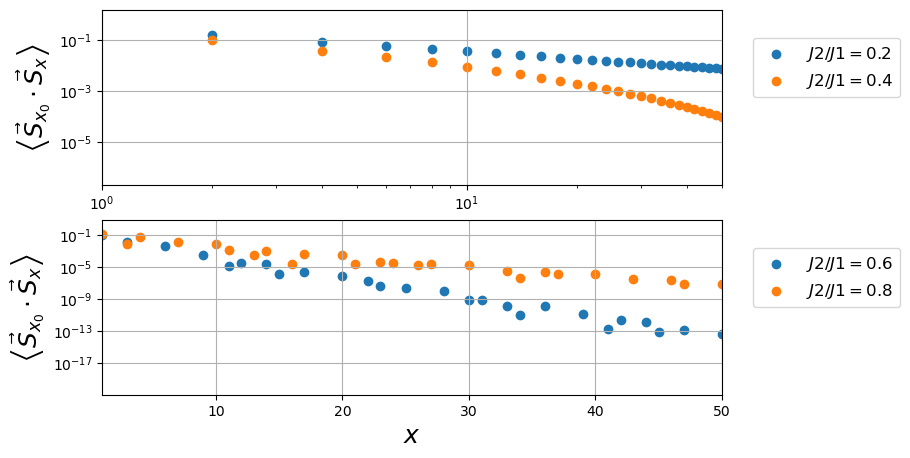

In [112]:
fig,ax = subplots(2,1,figsize=(8,5))
for (i,g) in enumerate(J2s)
    if g<0.5
        ax[1].scatter(0:1:div(N,2),correlations[i][100,100:200],label=L"J2/J1="*string(g))
    else
        ax[2].scatter(0:1:div(N,2),correlations[i][100,100:200],label=L"J2/J1="*string(g))
    end
end
for i in 1:2
    ax[i].legend(loc=(1.05,0.5),fontsize=12)
    ax[i].set_ylabel(L"\left< \vec{S}_{x_0} \cdot \vec{S}_x \right>",fontsize=18)
    ax[i].set_xlim([1,50])
end
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel(L"$x$", fontsize=18)

ax[1].grid()
ax[2].grid()

gcf()

# Spin-1 chain - Haldane gap
*In this problem we will consider the spin-1 bilinear-biquadtatic model*
$$H=\sum_i J_1 \vec{S}_i\cdot\vec{S}_{i+1} + J_2 \left( \vec{S}_i\cdot\vec{S}_{i+1} \right)^2 $$
*As discussed in the tutorial and in Problem Set 2, for $J_2/J_1 = 1/3$ the model is exactly solvable,and the ground state can be written explicitly as an MPS of bind dimension $M = 2$. At this point you observed that the ground state is four-fold degenerate for open boundary conditions and that the edges feature fractionalized spin-1/2 states.*

*In this problem you will show that when $J_2\rightarrow0$ the system remains in the same phase, i.e. it is gapped, and hosts fractionalized edge mods.*

## 2-1
*Consider different values of $J_2$ ranging between $1/3$ and $0$ and show that the system remains gapped within this range. To this end, perform finite-size scaling of the bulk gap. Note that to probe the bulk gap in this case you will need to look at the $S^z = 2$ sector, as the lowest energy state in the $S^z = 1$ sector simply accumulates the extra spin at the edges of the system (you'll check this in the next section).*

## 2-2
*For the same values of $J_2$ as above, calculate the gap between the $S^z = 1$ and $S^z = 0$ sectors.Show that the gap decays exponentially with system size (i.e. the states are degenerate in the thermodynamic limit). Calculate the local expectation value of $S^z$ along the chain in the lowest energy state with $S^z = 1$ and show that the total spin accumulated near each edge is $\pm 1/2$.*